### Feature Engineering - Handing Missing Values

#### Missing Completely at Random (MCAR)
- No relationship between the missing data and any other values
- Nothing systematic

In [15]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# Create an additional column with re-encoded 'Cabin' in terms of NaN
df['Cabin_null'] = np.where(df['Cabin'].isnull(), 1, 0)

# Find the proportion of null values
df['Cabin_null'].mean()

0.7710437710437711

In [8]:
# Group by 'Survived' and return the mean of 'Cabin_null' in the group
df.groupby('Survived')['Cabin_null'].mean()

# 60.23% of the survived and 87.76% of the dead with NaN in 'Cabin'

Survived
0    0.876138
1    0.602339
Name: Cabin_null, dtype: float64

#### Mean / Median / Mode Imputation
- Assumption: MCAR
- Replacing NaN with the most frequent occurance of the variables
- Easy, faster way to implement (Robust to outliers)
- Change or distortion in the original variance
- Impact on correlation

In [9]:
df = pd.read_csv('titanic.csv', usecols=['Age','Fare','Survived'])
df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [10]:
# Proporion of misssing values
df.isnull().mean()

Survived    0.000000
Age         0.198653
Fare        0.000000
dtype: float64

In [12]:
# Define a function to create an additional column with NaN replaced by the median of original column
def impute_nan(df, var):
    median = df[var].median()
    df[var + '_median'] = df[var].fillna(median)

In [13]:
impute_nan(df, 'Age')
df.head()

,Survived,Age,Fare,Age_median
0,0,22.0,7.2500,22.0
1,1,38.0,71.2833,38.0
2,1,26.0,7.9250,26.0
3,1,35.0,53.1000,35.0
4,0,35.0,8.0500,35.0


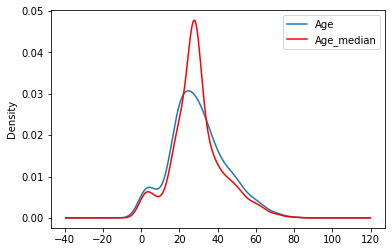

In [14]:
# Show the distribution of original vs NaN-replaced columns
fig = plt.figure()
ax = fig.add_subplot(111)
df.Age.plot(kind='kde', ax=ax)
df.Age_median.plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

#### Random Sample Imputation
- Assumption: MCAR
- Replace NaN with random observations from dataset
- Easy to impute
- Less distortion in variance
- Work for limited randomness

In [17]:
df = pd.read_csv('titanic.csv', usecols=['Age','Fare','Survived'])
df.isnull().sum()

Survived      0
Age         177
Fare          0
dtype: int64

In [18]:
def impute_nan(df, var):
    median = df[var].median()
    df[var + '_median'] = df[var].fillna(median)
    df[var + '_random'] = df[var]
    random_sample = df[var].dropna().sample(df[var].isnull().sum(), random_state=0)
    random_sample.index = df[df[var].isnull()].index
    df.loc[df[var].isnull(), var + '_random'] = random_sample

In [19]:
impute_nan(df, 'Age')

In [20]:
df.head()

,Survived,Age,Fare,Age_median,Age_random
0,0,22.0,7.2500,22.0,22.0
1,1,38.0,71.2833,38.0,38.0
2,1,26.0,7.9250,26.0,26.0
3,1,35.0,53.1000,35.0,35.0
4,0,35.0,8.0500,35.0,35.0


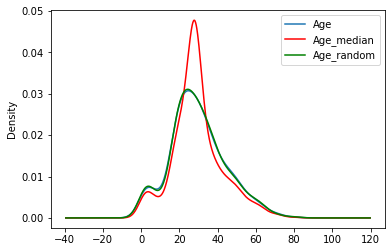

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
df.Age.plot(kind='kde', ax=ax)
df.Age_median.plot(kind='kde', ax=ax, color='red')
df.Age_random.plot(kind='kde', ax=ax, color='green')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

#### Capturing NaN values with new feature
- Not missing completely at random

In [27]:
df = pd.read_csv('titanic.csv', usecols=['Age','Fare','Survived'])

<AxesSubplot:>

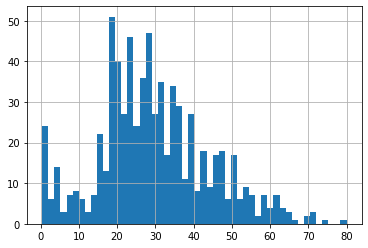

In [28]:
df.Age.hist(bins=50)

In [30]:
# Compute end distribution
extreme = df.Age.mean() + 3*df.Age.std()

In [31]:
def impute_nan(df, var):
    median = df[var].median()
    df[var + '_median'] = df[var].fillna(median)
    extreme = df[var].mean() + 3*df[var].std()
    df[var + "_end_dist"] = df[var].fillna(extreme)

<AxesSubplot:>

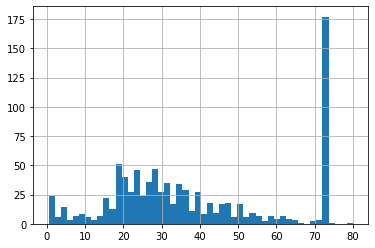

In [33]:
impute_nan(df, 'Age')

df['Age_end_dist'].hist(bins=50)

<AxesSubplot:>

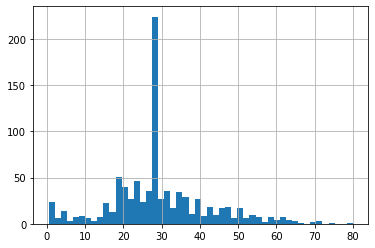

In [35]:
df['Age_median'].hist(bins=50)

In [36]:
df = pd.read_csv('titanic.csv', usecols=['Age', 'Fare', 'Survived'])

In [37]:
def impute_nan(df, var):
    median = df[var].median()
    df[var + "_median"] = df[var].fillna(median)
    extreme = df[var].mean() + 3*df[var].std()
    df[var + "_end_dist"]=df[var].fillna(extreme)
    df[var + "_random"] = df[var]
    random_sample = df[var].dropna().sample(df[var].isnull().sum(), random_state=0)
    random_sample.index = df[df[var].isnull()].index
    df.loc[df[var].isnull(), var + '_random'] = random_sample

In [38]:
impute_nan(df, 'Age')
df.head()

,Survived,Age,Fare,Age_median,Age_end_dist,Age_random
0,0,22.0,7.2500,22.0,22.0,22.0
1,1,38.0,71.2833,38.0,38.0,38.0
2,1,26.0,7.9250,26.0,26.0,26.0
3,1,35.0,53.1000,35.0,35.0,35.0
4,0,35.0,8.0500,35.0,35.0,35.0


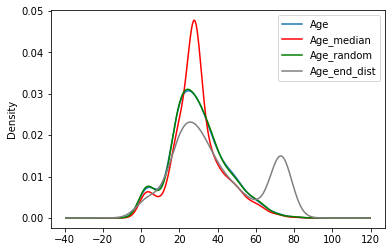

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
df['Age'].plot(kind='kde', ax=ax)
df.Age_median.plot(kind='kde', ax=ax, color='red')
df.Age_random.plot(kind='kde', ax=ax, color='green')
df.Age_end_dist.plot(kind='kde', ax=ax, color='grey')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

#### Arbitrary Value Imputation
- Replacing NaN by an arbitrary value
- Easy to implement
- Distort the original distribution of the variance
- May mask the predictive power of the original variance by distortion of distribution
- Hard to decide what value to use

In [40]:
df = pd.read_csv('titanic.csv', usecols=['Age', 'Fare', 'Survived'])

In [41]:
def impute_nan(df, var):
    df[var + '_zero'] = df[var].fillna(0)
    df[var + '_hundred'] = df[var].fillna(100)

In [42]:
impute_nan(df, 'Age')

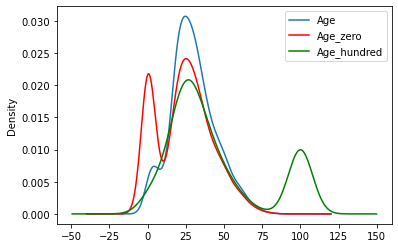

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)
df.Age.plot(kind='kde', ax=ax)
df.Age_zero.plot(kind='kde', ax=ax, color='red')
df.Age_hundred.plot(kind='kde', ax=ax, color='green')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')